In [214]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm

## 1. Importar los datos

Se importan los datos escalados que contienen las variables numéricas ya listas para el modelo.

In [215]:
autorenew_scaled = pd.read_csv("../datos/autorenew_scaled.csv",index_col=0)
autorenew_scaled.head()

,index,datecrawled,price,abtest,vehicletype,gearbox,model,monthofregistration,fueltype,brand,notrepaireddamage,datecreated,postalcode,lastseen,fueltype_grouped,brand_grouped,powercv_robust,kilometer_robust,yearofregistration_robust
level_0,,,,,,,,,,,,,,,,,,,
0,0.0,2016-03-24 11:52:17,480.0,test,coupe,manually,golf,0.0,petrol,volkswagen,no,2016-03-24,70435,2016-04-07 03:16:57,petrol,volkswagen,-0.291859,0.0,-1.111111
1,1.0,2016-03-24 10:58:45,18300.0,test,coupe,manually,c2,5.0,diesel,audi,yes,2016-03-24,66954,2016-04-07 01:46:50,diesel,audi,1.213518,-1.0,0.888889
2,2.0,2016-03-14 12:52:21,9800.0,test,suv,automatic,grand,8.0,diesel,jeep,no,2016-03-14,90480,2016-04-05 12:47:46,diesel,other,0.814132,-1.0,0.111111
3,3.0,2016-03-17 16:54:04,1500.0,test,small car,manually,golf,6.0,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17,petrol,volkswagen,-0.522273,0.0,-0.222222
4,4.0,2016-03-31 17:25:20,3600.0,test,small car,manually,fabia,7.0,diesel,skoda,no,2016-03-31,60437,2016-04-06 10:17:21,diesel,skoda,-0.614439,-2.4,0.555556


Se importan las variables categóricas encodeadas ya listar para ser introducidas al modelo.

In [216]:
autorenew_encoded = pd.read_csv("../datos/autorenew_df_encoded.csv", index_col=0)
autorenew_encoded.head()

,monthofregistration_name,gearbox_manually,notrepaireddamage_yes,kilometer,vehicletype,fueltype,brand,monthofregistration_name.1
0,Desconocido,1.0,0.0,12.0,4367.0,3966.0,4577.0,2239.0
1,May,1.0,1.0,11.0,4367.0,6979.0,6598.0,4921.0
2,Aug,0.0,0.0,11.0,9302.0,6979.0,5690.0,4970.0
3,Jun,1.0,0.0,12.0,2695.0,3966.0,4577.0,5044.0
4,Jul,1.0,0.0,9.0,2695.0,6979.0,5885.0,5226.0


Se concatenan ambas:

In [217]:
autorenew_preprocessed = pd.concat([autorenew_scaled[["price"]],autorenew_scaled.filter(like="robust"),autorenew_encoded.iloc[:,1:]],axis=1)
autorenew_preprocessed.head()

,price,powercv_robust,kilometer_robust,yearofregistration_robust,gearbox_manually,notrepaireddamage_yes,kilometer,vehicletype,fueltype,brand,monthofregistration_name.1
0,480.0,-0.291859,0.0,-1.111111,1.0,0.0,12.0,4367.0,3966.0,4577.0,2239.0
1,18300.0,1.213518,-1.0,0.888889,1.0,1.0,11.0,4367.0,6979.0,6598.0,4921.0
2,9800.0,0.814132,-1.0,0.111111,0.0,0.0,11.0,9302.0,6979.0,5690.0,4970.0
3,1500.0,-0.522273,0.0,-0.222222,1.0,0.0,12.0,2695.0,3966.0,4577.0,5044.0
4,3600.0,-0.614439,-2.4,0.555556,1.0,0.0,9.0,2695.0,6979.0,5885.0,5226.0


Se dropean los posibles nulos que hubieran quedado en la variable respuesta tras la gestión de outliers.

In [218]:
autorenew_preprocessed.dropna(subset="powercv_robust",inplace=True)

# 2. Entrenamiento del modelo

Se definen las pedrictoras en la variable X y la objetivo en la y. Se realiza una partición de entrenamiento-test y se ajusta el modelo de Regresión Lineal a los datos de entrenamiento.

In [219]:
X = autorenew_preprocessed.drop("price", axis=1).reset_index(drop=True)
y = autorenew_preprocessed["price"]

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

modelo_lineal = LinearRegression()
modelo_lineal.fit(X_train, y_train)

LinearRegression()

Con el modelo ajustado, se generan las predicciones tanto sobre el subconjunto de entrenamiento como sobre el de test, para poder evaluar más adelante si existe sobreajuste o subajuste entre las diferencias de R cuadrado de ambos.

In [224]:
y_train_pred = modelo_lineal.predict(X_train)
y_test_pred = modelo_lineal.predict(X_test)
y_test_pred = pd.DataFrame(y_test_pred,columns=["price"])

Existen predicciones negativas que, desde el punto de vista de la recta de regresión tienen sentido, pero en nuestro caso no son deseables. Se podría forzar la curva a tener un intercept 0 para que este problema no ocurra, o tal vez usar una transformada de log(price) para predecir sobre ella.

In [225]:
metricas = {
    'train': {
        'r2_score': r2_score(y_train, y_train_pred),
        'MAE': mean_absolute_error(y_train, y_train_pred),
        'MSE': mean_squared_error(y_train, y_train_pred),
        'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred))
    },
    'test': {
        'r2_score': r2_score(y_test, y_test_pred),
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'MSE': mean_squared_error(y_test, y_test_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))

    }
}
pd.DataFrame(metricas).T

,r2_score,MAE,MSE,RMSE
train,0.441843,2449.436941,1.138276e+07,3373.834398
test,0.444475,2444.412529,1.139825e+07,3376.129726


Las métricas de R2 indican que no existe sobreajuste, pero en realidad el framework sobre el cual se ha aplicado el procesamiento en los pasos de gestión de outliers, encoding, escalado y gestión de nulos, que puede haber provocado una fuga de datos. Habría que contrastarlo realizando el preprocesamiento en un framework de pipelining que aisle el train del test más adelante.

Observemos la distribución de las predicciones.

,price
count,96815.000000
mean,4502.211755
std,2993.151017
min,-3583.315977
25%,2274.797395
50%,4108.186656
75%,6340.657190
max,18229.216721


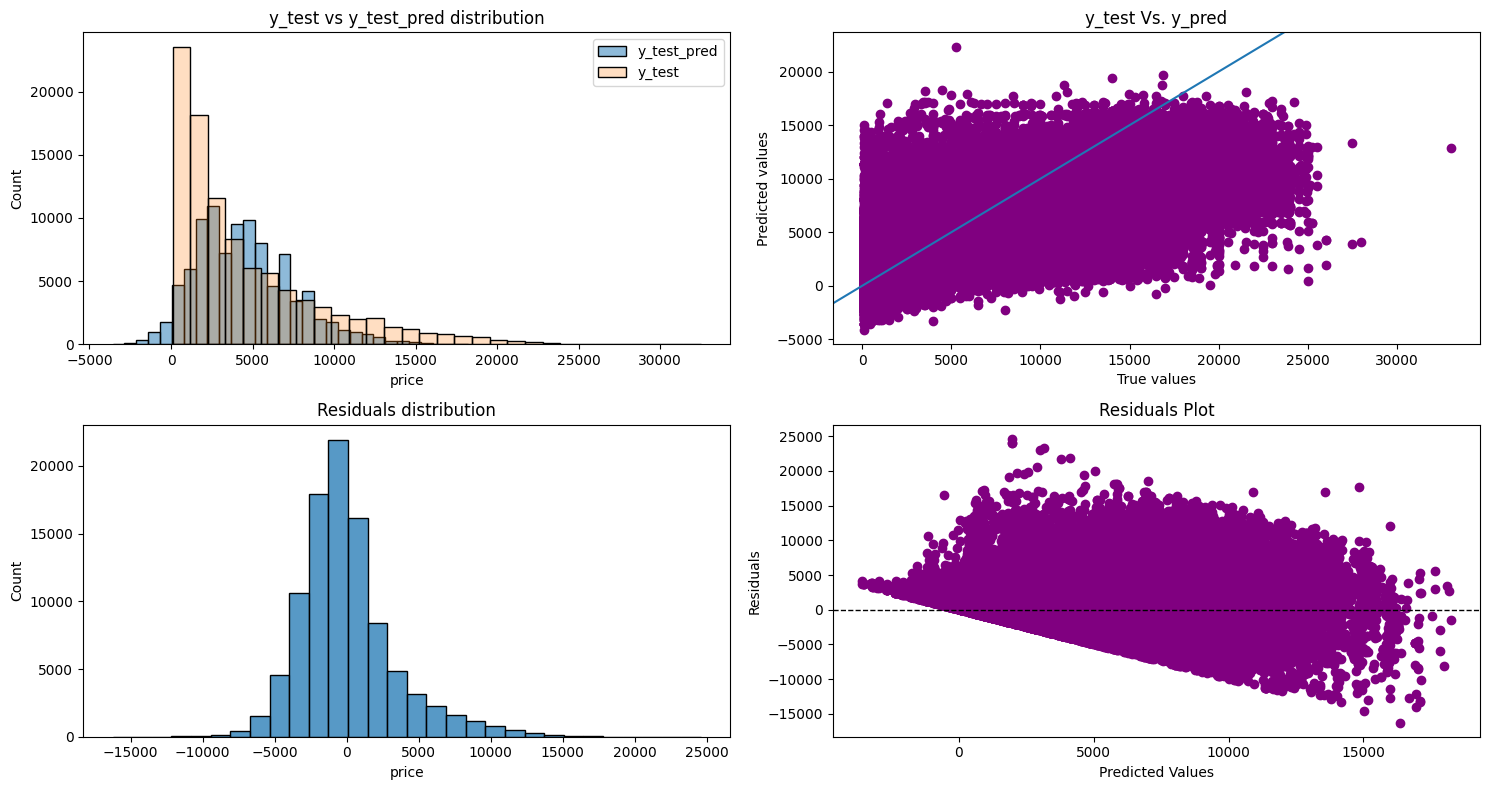

In [243]:
display(y_test_pred.describe())

fig, axes = plt.subplots(2,2, figsize=(15,8))
axes = axes.flat

sns.histplot(y_test_pred, bins=30, ax=axes[0], label="y_test_pred")
sns.histplot(y_test, bins=30, ax=axes[0], alpha=0.25, label="y_test")
axes[0].legend()
axes[0].set_title('y_test vs y_test_pred distribution')

axes[1].scatter(y_train.reset_index(drop=True), y_train_pred, color='purple')

axes[1].axline([0, 0], [1, 1])
axes[1].set_title('y_test Vs. y_pred')
axes[1].set_xlabel('True values')
axes[1].set_ylabel('Predicted values')


residuals = y_test.reset_index(drop=True) - y_test_pred["price"]

sns.histplot(residuals, bins=30, ax=axes[2])
axes[2].set_title('Residuals distribution')

# Plot residuals
axes[3].scatter(y_test_pred, residuals, color='purple')
axes[3].axhline(0, linestyle='--', color='black', linewidth=1)
axes[3].set_title('Residuals Plot')
axes[3].set_xlabel('Predicted Values')
axes[3].set_ylabel('Residuals')



plt.tight_layout()
plt.show()

Se observa en el análisis de las predicciones que:

- La y_pred tiene valores negativos, que no tiene sentido para el rango de valores ni de entrenamiento ni de test. La distribución de la variable original es exponencial negativa, mientras que la distribución de valores predichos se asemeja a una normal
- Las predicciones sobre predicen en su mayoría para valores bajos, aunque también generan predicciones negativas como se ha comentado hace un momento. Conforme aumenta el valor de la objetivo, aumenta el numero de subpredicciones. Es posible que fuera necesario utilizar algún tipo de transformación.
- La distribución de los errores se asemeja a una normal, lo cual, validado por tests de contraste, apoyaría el uso de una regresión lineal.
- La relación entre los residuals y los valores predichos, como indicaba el plot de 'y_test Vs. y_pred' indica que hay una tendencia a la sobre predicción conforme aumentan los valores predichos. No queda claro por el análisis visual si es un patrón de tubo o de embudo, por lo que sería necesario realizar tests de homocedasticidad para comprobar si esta se cumple en los errores.